# OverFitting Dataset データ検証ノートブック

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os

# Set font for proper display of text
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Use a font that supports English well
try:
    import matplotlib.font_manager as fm
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']
except:
    pass

In [4]:
# Load data
data_path = '../../data/Datasets/overfitting_dataset.npz'
data = np.load(data_path)

trajectories = data['trajectories']  # (840, 101, 2) - trajectory data
conditions = data['conditions']      # (840, 3) - condition vectors

print(f"Dataset Overview:")
print(f"Trajectories: {trajectories.shape} (samples, time_steps, coordinates)")
print(f"Conditions: {conditions.shape} (samples, condition_dims)")
print(f"\nCondition vector ranges:")
for i in range(conditions.shape[1]):
    print(f"Condition {i}: min={conditions[:, i].min():.3f}, max={conditions[:, i].max():.3f}")

Dataset Overview:
Trajectories: (840, 101, 2) (samples, time_steps, coordinates)
Conditions: (840, 3) (samples, condition_dims)

Condition vector ranges:
Condition 0: min=-2.430, max=6.744
Condition 1: min=-1.535, max=3.899
Condition 2: min=-0.377, max=24.713


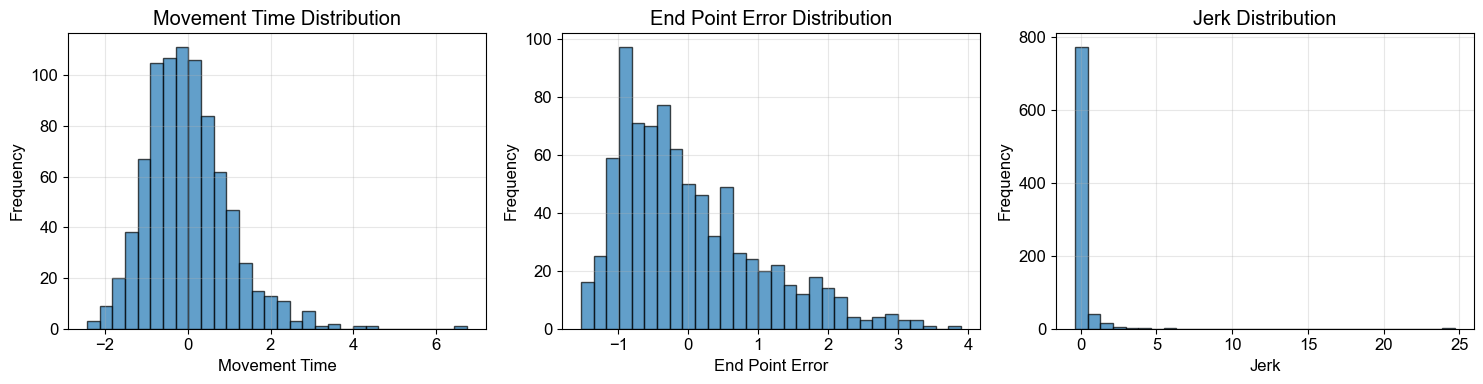

In [5]:
# Visualize condition vector distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
name_of_distributions = ["Movement Time", "End Point Error", "Jerk"]

for i in range(3):
    axes[i].hist(conditions[:, i], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{name_of_distributions[i]} Distribution')
    axes[i].set_xlabel(f'{name_of_distributions[i]}')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
def plot_trajectory_and_conditions(sample_idx):
    """Plot trajectory data and condition vectors for specified sample"""

    # Get trajectory data
    traj = trajectories[sample_idx]  # (101, 2)
    cond = conditions[sample_idx]    # (3,)

    # Create plots
    fig = plt.figure(figsize=(16, 6))

    # Trajectory plot (XY plane)
    ax1 = plt.subplot(2, 3, 1)
    plt.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2, alpha=0.8)
    plt.scatter(traj[0, 0], traj[0, 1], c='green', s=100, marker='o', label='Start', zorder=5)
    plt.scatter(traj[-1, 0], traj[-1, 1], c='red', s=100, marker='s', label='End', zorder=5)
    plt.title(f'Trajectory (XY Plane)\nSample #{sample_idx}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')

    # X coordinate time series
    ax2 = plt.subplot(2, 3, 2)
    time_steps = np.arange(len(traj))
    plt.plot(time_steps, traj[:, 0], 'r-', linewidth=2, label='X Coordinate')
    plt.title('X Coordinate Time Series')
    plt.xlabel('Time Step')
    plt.ylabel('X Coordinate')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Y coordinate time series
    ax3 = plt.subplot(2, 3, 3)
    plt.plot(time_steps, traj[:, 1], 'b-', linewidth=2, label='Y Coordinate')
    plt.title('Y Coordinate Time Series')
    plt.xlabel('Time Step')
    plt.ylabel('Y Coordinate')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Condition vector visualization
    ax4 = plt.subplot(2, 3, 4)
    bars = plt.bar(['Cond 0', 'Cond 1', 'Cond 2'], cond,
                   color=['skyblue', 'lightcoral', 'lightgreen'],
                   edgecolor='black', alpha=0.8)
    plt.title('Condition Vector')
    plt.ylabel('Condition Value')
    plt.grid(True, alpha=0.3, axis='y')

    # Display condition values on bars
    for bar, value in zip(bars, cond):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # Velocity plot
    ax5 = plt.subplot(2, 3, 5)
    velocity = np.diff(traj, axis=0)
    speed = np.linalg.norm(velocity, axis=1)
    plt.plot(time_steps[1:], speed, 'purple', linewidth=2)
    plt.title('Speed Magnitude')
    plt.xlabel('Time Step')
    plt.ylabel('Speed')
    plt.grid(True, alpha=0.3)

    # Trajectory statistics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Calculate statistics
    trajectory_length = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1))
    start_point = traj[0]
    end_point = traj[-1]
    displacement = np.linalg.norm(end_point - start_point)

    stats_text = f"""Trajectory Statistics:

Sample Number: {sample_idx}
Trajectory Length: {trajectory_length:.3f}
Displacement: {displacement:.3f}

Start Point: ({start_point[0]:.3f}, {start_point[1]:.3f})
End Point: ({end_point[0]:.3f}, {end_point[1]:.3f})

X Range: [{traj[:, 0].min():.3f}, {traj[:, 0].max():.3f}]
Y Range: [{traj[:, 1].min():.3f}, {traj[:, 1].max():.3f}]

Average Speed: {speed.mean():.3f}
Max Speed: {speed.max():.3f}"""

    ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Display detailed condition vector information
    print(f"\n=== Sample #{sample_idx} Detailed Information ===")
    print(f"Condition Vector: [{cond[0]:.6f}, {cond[1]:.6f}, {cond[2]:.6f}]")
    print(f"Trajectory Data Shape: {traj.shape}")
    print(f"Total Trajectory Length: {trajectory_length:.6f}")
    print(f"Start→End Displacement: {displacement:.6f}")

In [7]:
# Interactive sample selection widget
sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(trajectories)-1,
    step=1,
    description='Sample Number:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='500px')
)

# Random sample selection button
random_button = widgets.Button(
    description='Random Selection',
    button_style='info',
    tooltip='Select a random sample'
)

def on_random_button_click(b):
    sample_slider.value = np.random.randint(0, len(trajectories))

random_button.on_click(on_random_button_click)

# Display widgets
controls = widgets.HBox([sample_slider, random_button])
display(controls)

# Interactive plot
interactive_plot = widgets.interactive(plot_trajectory_and_conditions, sample_idx=sample_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Sample Number:', layout=Layout(width='500px'), max=839, …

In [8]:
# Compare multiple samples
def compare_samples(num_samples=6):
    """Display multiple samples for comparison"""

    # Randomly select samples
    sample_indices = np.random.choice(len(trajectories), num_samples, replace=False)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):
        traj = trajectories[idx]
        cond = conditions[idx]

        ax = axes[i]

        # Plot trajectory
        ax.plot(traj[:, 0], traj[:, 1], 'b-', linewidth=2, alpha=0.8)
        ax.scatter(traj[0, 0], traj[0, 1], c='green', s=80, marker='o', zorder=5)
        ax.scatter(traj[-1, 0], traj[-1, 1], c='red', s=80, marker='s', zorder=5)

        ax.set_title(f'Sample #{idx}\nConditions: [{cond[0]:.2f}, {cond[1]:.2f}, {cond[2]:.2f}]',
                    fontsize=10)
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

    print("Selected samples:", sample_indices)

# Execute comparison display
compare_button = widgets.Button(
    description='Compare 6 Samples',
    button_style='success',
    layout=widgets.Layout(width='200px')
)

def on_compare_button_click(b):
    compare_samples()

compare_button.on_click(on_compare_button_click)
display(compare_button)

Button(button_style='success', description='Compare 6 Samples', layout=Layout(width='200px'), style=ButtonStyl…

=== Dataset Statistical Analysis ===
Total Samples: 840
Time Steps: 101
Coordinate Dimensions: 2
Condition Vector Dimensions: 3

Trajectory Length Statistics:
  Mean: 1.1978
  Std Dev: 0.1741
  Min: 1.0190
  Max: 1.6335

Displacement Statistics:
  Mean: 1.1496
  Std Dev: 0.1555
  Min: 0.8168
  Max: 1.4131

Condition Vector Statistics:
  Condition 0: Mean=-0.0000, Std=1.0000, Range=[-2.4299, 6.7443]
  Condition 1: Mean=-0.0000, Std=1.0000, Range=[-1.5348, 3.8989]
  Condition 2: Mean=-0.0000, Std=1.0000, Range=[-0.3767, 24.7125]


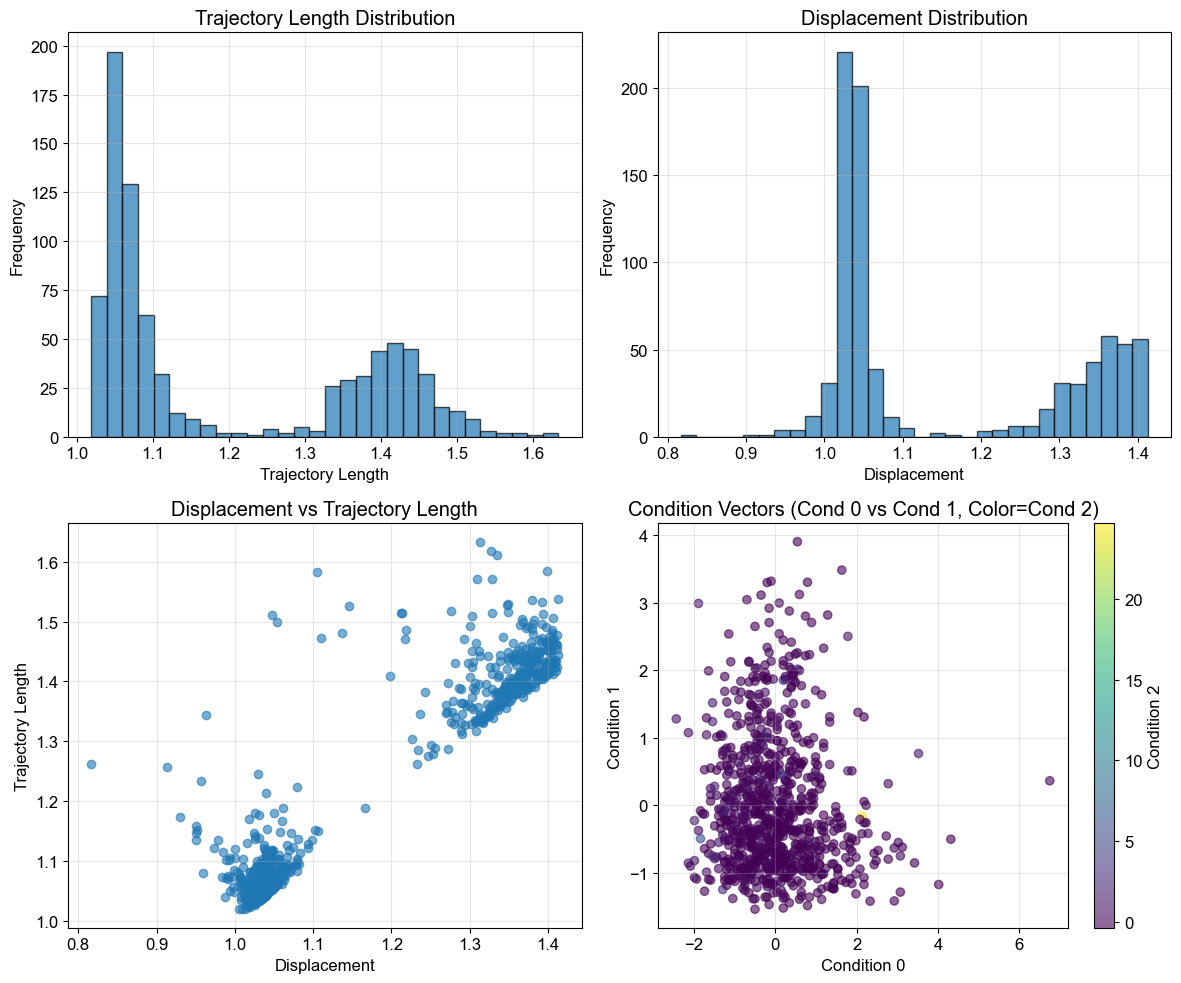

In [9]:
# Dataset-wide statistical analysis
def analyze_dataset():
    """Statistical analysis of the entire dataset"""

    print("=== Dataset Statistical Analysis ===")
    print(f"Total Samples: {len(trajectories)}")
    print(f"Time Steps: {trajectories.shape[1]}")
    print(f"Coordinate Dimensions: {trajectories.shape[2]}")
    print(f"Condition Vector Dimensions: {conditions.shape[1]}")

    # Trajectory length statistics
    trajectory_lengths = []
    displacements = []

    for i in range(len(trajectories)):
        traj = trajectories[i]
        length = np.sum(np.linalg.norm(np.diff(traj, axis=0), axis=1))
        displacement = np.linalg.norm(traj[-1] - traj[0])
        trajectory_lengths.append(length)
        displacements.append(displacement)

    trajectory_lengths = np.array(trajectory_lengths)
    displacements = np.array(displacements)

    print(f"\nTrajectory Length Statistics:")
    print(f"  Mean: {trajectory_lengths.mean():.4f}")
    print(f"  Std Dev: {trajectory_lengths.std():.4f}")
    print(f"  Min: {trajectory_lengths.min():.4f}")
    print(f"  Max: {trajectory_lengths.max():.4f}")

    print(f"\nDisplacement Statistics:")
    print(f"  Mean: {displacements.mean():.4f}")
    print(f"  Std Dev: {displacements.std():.4f}")
    print(f"  Min: {displacements.min():.4f}")
    print(f"  Max: {displacements.max():.4f}")

    # Condition vector statistics
    print(f"\nCondition Vector Statistics:")
    for i in range(conditions.shape[1]):
        print(f"  Condition {i}: Mean={conditions[:, i].mean():.4f}, "
              f"Std={conditions[:, i].std():.4f}, "
              f"Range=[{conditions[:, i].min():.4f}, {conditions[:, i].max():.4f}]")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Trajectory length distribution
    axes[0, 0].hist(trajectory_lengths, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 0].set_title('Trajectory Length Distribution')
    axes[0, 0].set_xlabel('Trajectory Length')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)

    # Displacement distribution
    axes[0, 1].hist(displacements, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Displacement Distribution')
    axes[0, 1].set_xlabel('Displacement')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)

    # Trajectory length vs displacement
    axes[1, 0].scatter(displacements, trajectory_lengths, alpha=0.6)
    axes[1, 0].set_title('Displacement vs Trajectory Length')
    axes[1, 0].set_xlabel('Displacement')
    axes[1, 0].set_ylabel('Trajectory Length')
    axes[1, 0].grid(True, alpha=0.3)

    # Condition vector scatter plot (condition 0 vs condition 1)
    scatter = axes[1, 1].scatter(conditions[:, 0], conditions[:, 1],
                                c=conditions[:, 2], cmap='viridis', alpha=0.6)
    axes[1, 1].set_title('Condition Vectors (Cond 0 vs Cond 1, Color=Cond 2)')
    axes[1, 1].set_xlabel('Condition 0')
    axes[1, 1].set_ylabel('Condition 1')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='Condition 2')

    plt.tight_layout()
    plt.show()

analyze_dataset()